In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
%matplotlib inline

import data_prep
from yleana_util import *

In [5]:
df = data_prep.main()
df.head()

,firstName,lastName,testID,testQuestionNumber,testSectionNumber,type,CorrectAnswer,Studentsanswer,topic,difficulty,correct,numTopics,id,class
0,Aeson,Purse,OLSAT8.PT2,1,2,math,A,B,backsolving,easy,0,3,0,A
1,Aeson,Purse,OLSAT8.PT2,1,2,math,A,B,equations,easy,0,3,0,A
2,Aeson,Purse,OLSAT8.PT2,1,2,math,A,B,substitution,easy,0,3,0,A
3,Aeson,Purse,OLSAT7.PT1,1,2,sentence,E,C,DB,easy,0,2,0,A
4,Aeson,Purse,OLSAT7.PT1,1,2,sentence,E,C,GC,easy,0,2,0,A


In [37]:
def groupData(df,columns,statVar):
    '''
    group the data by the columns, aggregating the statVar with sum, mean, std
    args:
        df: dataframe
        columns:columns to group by
        statVar: column to aggregate.  
    '''
    subDF = df[columns+[statVar]]
    grouped = subDF.groupby(columns,sort=True)
    groupedDF = grouped.agg([np.size,np.sum, np.mean,np.std])[statVar]
    groupedDF = groupedDF.reset_index()
    return groupedDF

def buildFocusTable(df,firstName,testID,subject,passingThreshold=0.6,minWrong=5):
    '''
    Get a data frame of topics in which this student is farthest behind the rest of the class, weighted by topic weight.
    These are recommendations for further study
    args:
        df: raw dataframe
        testID: test from which you want to build a recommendation table
        firstName:first name of student
        subject: math, reading, sentence, or writing
        passingThreshold: minimum score to pass 
        minWrong: minimum number of wrong answers to make a recommendation
    returns:
        rec: Dataframe of topics in which this student is farthest behind the rest of the class,
                ranked by the difference between this student's % correct and the class avg.
    '''
    
    #optionally specify a testID, otherwise use all tests
    if testID is not None:
        df = df.loc[df['testID']==testID,:].copy()
    df = df.loc[df['type']==subject,:]
        
    #list of topics
    topicsDF = getTopicWeight(df)
    
    #get student and class performance on each topic
    studentPerf,classPerf = getClassAvg(df,columns=['firstName','type','topic'],statVar='correct',passingThreshold=passingThreshold)
    classPerf = classPerf.sort('numStudentsGivenTopic')
    q1 = pd.merge(studentPerf,classPerf,on=['type','topic'])
    q2 = pd.merge(q1,topicsDF, how='left',on=['type','topic'])
    rec = q2[['firstName','type','topic','topicWeight','wrong','score','classAvg']].copy()
    rec['scoreDiff']=rec['score'] - rec['classAvg']
    rec['weightedScoreDiff'] = rec['scoreDiff']*rec['topicWeight']
    
    #only recommend areas where the student got at least a few wrong
    rec = rec[rec['wrong']>=minWrong]
    
    for col in ['topicWeight','score','classAvg','scoreDiff']:
        rec[col] = rec[col].round(2)
    rec.sort('weightedScoreDiff',ascending=True, inplace=True)
    return rec.loc[rec['firstName']==firstName].head()

buildFocusTable(df,'Clementina',testID='OLSAT7.PT1',subject='math')

,firstName,type,topic,topicWeight,wrong,score,classAvg,scoreDiff,weightedScoreDiff
87,Clementina,math,backsolving,0.03,5,0.17,0.27,-0.10,-0.003205
495,Clementina,math,substitution,0.06,7,0.42,0.27,0.15,0.008974
175,Clementina,math,equations,0.09,8,0.53,0.29,0.24,0.020513
551,Clementina,math,word problem,0.14,16,0.43,0.27,0.16,0.023077


In [24]:
def buildOpportunityTable(df,firstName,testID,subject):
    '''
    Get a data frame of topics in which this student got the most wrong answers, 
    optionally specifying a difficulty level.
    args:
        df: raw dataframe
        testID: test from which you want to build a recommendation table
        firstName:first name of student
        subject: math, reading, sentence, or writing
        passingThreshold: minimum score to pass 
        minWrong: minimum number of wrong answers to make a recommendation
    returns:
        rec: Dataframe of topics in which this student is farthest behind the rest of the class,
                ranked by the difference between this student's % correct and the class avg.
    '''
    
    #optionally specify a testID, otherwise use all tests
    if testID is not None:
        df = df.loc[df['testID']==testID,:].copy()
    df = df.loc[df['type']==subject,:]
    
    rec = buildRecTable(df,testID)
    rec.sort('wrong',ascending=False, inplace=True)
    return rec.loc[rec['firstName']==firstName].head()
    
buildOpportunityTable(df,'Aeson',testID='OLSAT8.PT2')

,firstName,type,topic,difficulty,topicWeight,wrong,score,classAvg,scoreDiff,weightedScoreDiff
834,Aeson,reading,LP - long passage,med,0.22,23,0.15,0.21,-0.06,-0.013806
538,Aeson,math,word problem,med,0.14,17,0.06,0.21,-0.15,-0.020572
922,Aeson,reading,ZI,med,0.15,15,0.21,0.36,-0.15,-0.022669
833,Aeson,reading,LP - long passage,hard,0.22,10,0.00,0.21,-0.21,-0.045666
946,Aeson,reading,ZO,med,0.10,8,0.11,0.12,-0.00,-0.000448


In [25]:
def buildCarelessTable(df,firstName,testID):
    rec = buildRecTable(df,testID)
    rec = rec[rec['difficulty']=='easy']
    rec.sort('wrong',ascending=False, inplace=True)
    return rec.loc[rec['firstName']==firstName].head()

buildCarelessTable(df,'Aeson','OLSAT8.PT2')

,firstName,type,topic,difficulty,topicWeight,wrong,score,classAvg,scoreDiff,weightedScoreDiff
1200,Aeson,sentence,SB,easy,0.25,8,0.11,0.39,-0.28,-0.069444
536,Aeson,math,word problem,easy,0.14,6,0.25,0.21,0.04,0.005810
1184,Aeson,sentence,DB,easy,0.28,6,0.40,0.52,-0.12,-0.034722
1216,Aeson,sentence,definition,easy,0.22,5,0.38,0.44,-0.06,-0.013889
176,Aeson,math,fractions,easy,0.03,5,0.00,0.25,-0.25,-0.006281


In [8]:
def getMistakes(student,difficulty):
    newDF = df.loc[(df['firstName']==student) & (df['difficulty']==difficulty),:].copy()
    wrongs = getMostWrongs(newDF,'math')
    return wrongs.head(2)

getMistakes('Clementina','easy')

,type,topic,firstName,size,sum,mean,std,meanNumTopics,wrong
93,math,word problem,Clementina,68,56,0.823529,0.384054,3.073529,12
46,math,"letter in the question, letter in the answer, ...",Clementina,9,2,0.222222,0.440959,3.888889,7


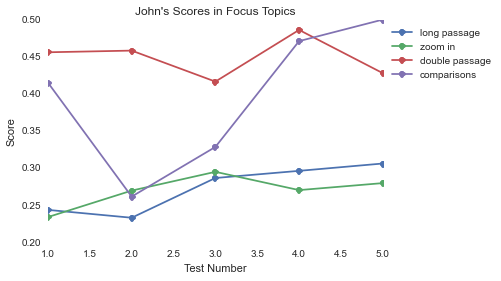

In [11]:
def plotTrends(trendsDF,title):
    subjects = trendsDF.type.unique()
    for subject in subjects:
        foo = trendsDF[trendsDF['type']==subject]
        x = foo['testNum']
        y = foo['avgScore']
        plt.plot(x,y,'-o')
        plt.label=subject

    plt.ylabel('Score')
    plt.xlabel('Test Number')
    plt.title(title)
    foo = ['long passage','zoom in','double passage','comparisons']
    plt.legend(foo,bbox_to_anchor=(1, 1), loc=2)

ol = getTrendsOverTime(df,'OL')
plotTrends(ol,'John\'s Scores in Focus Topics')